# FETAL CARDIOTOCOGRAPHY CLASSIFICATION

The objective of this analysis is to indicate the conditions under which fetal health is determined to be suspect or pathological. The data is derived from fetal cardiotocographic monitors which measure the vitals of a fetus in utero. Additional analytical features have been added to the dataset. <br>

The analysis will attempt to show which features have the greatest impact on our ability to determine the class in the “NSP” feature. As such, the analysis will prioritize interpretability over predictive power.  The error metric to be used for evaluating the models will be “recall” as we want to reduce the occurrence of false negatives. In other words it is better to falsely label a “Normal” pattern as “Suspect” or “Pathological” than to falsely label a “Suspect” or “Pathological” pattern as “Normal.”

# Prelim

### Import Libraries and Data

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline
sns.set_style('white')

from joblib import Parallel, delayed
import multiprocessing

In [2]:
data_raw = pd.read_csv('CTG.csv')

In [3]:
data_raw.columns

Index(['FileName', 'Date', 'SegFile', 'b', 'e', 'LBE', 'LB', 'AC', 'FM', 'UC',
       'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS', 'DP', 'DR', 'Width', 'Min',
       'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance',
       'Tendency', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP',
       'CLASS', 'NSP'],
      dtype='object')

### Remove features not used in analysis

In [4]:
remove_cols = ['FileName', 'Date', 'SegFile', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP','CLASS']
data = data_raw.drop(labels=remove_cols, axis=1)

### Feature overview

An overview of the features is as follows.<br>
_(see [appendix](#Full-List-of-Features-with-Definitions) for a detailed listing of features with definitions)_ <br><br>

__Date__  - Date of examination <br>

__b, e__ - Timestamp features indicating the beginning ('b') and end ('e') of the reading <br>

__AC, FM, UC, DL, DS, DP, DR__ - Features counting the occurrences of certain indicators (ex. Fetal movements ('FM'), uterine contractions ('UC'))<br>

__LBE, LB, ASTV, mSTV, ALTV, MLTV__ - Analytical features indicating baseline values of fetal heart rate, as well as averages and percentages of heart rate variability<br>

__Width, Min, Max, Nmax, Nzeros, Mode, Mean, Median, Variance, Tendency__ - Analytical features indicating the size and shape of the histogram of fetal heart rate. “Nmax” and “Nzeros” are respectively a count of the local maxima and of the zero values.<br>

__NSP__  - Classification feature indicating whether the fetal health is:
* 1 - Normal<br>
* 2 - Suspect<br>
* 3 - Pathological<br>

# EDA:

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
b,2126.0,878.439793,894.084748,0.0,55.0,538.0,1521.00,3296.0
e,2126.0,1702.877234,930.919143,287.0,1009.0,1241.0,2434.75,3599.0
LBE,2126.0,133.303857,9.840844,106.0,126.0,133.0,140.00,160.0
LB,2126.0,133.303857,9.840844,106.0,126.0,133.0,140.00,160.0
AC,2126.0,2.722484,3.560850,0.0,0.0,1.0,4.00,26.0
FM,2127.0,7.503056,39.030452,0.0,0.0,0.0,2.00,564.0
UC,2127.0,3.669017,2.877148,0.0,1.0,3.0,5.00,23.0
ASTV,2127.0,47.008933,17.210648,12.0,32.0,49.0,61.00,87.0
MSTV,2127.0,1.335449,0.891543,0.2,0.7,1.2,1.70,7.0
ALTV,2127.0,9.884814,18.476534,0.0,0.0,0.0,11.00,91.0


### Remove unnecessary features

It appears the features 'LB' and 'LBE' have the same data points. This was confirmed upon closer inspection, and therefore we will remove the redundant feature 'LBE'.

In [6]:
data = data.drop('LBE', axis=1)

The table above show that the 'DR' column of the value zero for every record. Therefore we can remove that feature since it provides no useful information.

In [7]:
data = data.drop('DR', axis=1)

### Remove Nulls

We will search for and remove any records with null values.

In [8]:
print(f'Records with null values in the data: {len(data[data.isnull().any(axis=1)])}')

data_nulls = data[data.isnull().any(axis=1)].index
data = data.drop(data_nulls, axis=0)

print(f'Are there any null values still in the data? {data.isnull().values.any()}')

Records with null values in the data: 3
Are there any null values still in the data? False


### Convert integer-like features to integer datatype

The data types shown below indicate that all features are coded as floats. However most are recorded like integers in that they never have a nonzero value to the right of the decimal point. For those instances we should convert the integer-like features to integer data type.

In [9]:
print(f'Count of features by data type:\r\n{data.dtypes.value_counts()}')

Count of features by data type:
float64    24
dtype: int64


In [10]:
# Divide the features into those with decimal values and those without
float_cols = data[data != round(data,0)].any()
int_list = list(float_cols[float_cols == False].index)

# Convert columns with no decimals to integer
for columns in int_list:
    data[columns] = data[columns].astype(int)

print(f'Count of features by data type:\r\n{data.dtypes.value_counts()}')

Count of features by data type:
int32      22
float64     2
dtype: int64


### View distribution of 'NSP' classes for each feature

In [11]:
#temporarily remove timstamp features
data_pp = data.drop(['b', 'e'], axis=1)

Below we see the distribution of the classes within each feature. After data cleaning and tranformation, we will examine these distributions again to see the extent to which they have changed.

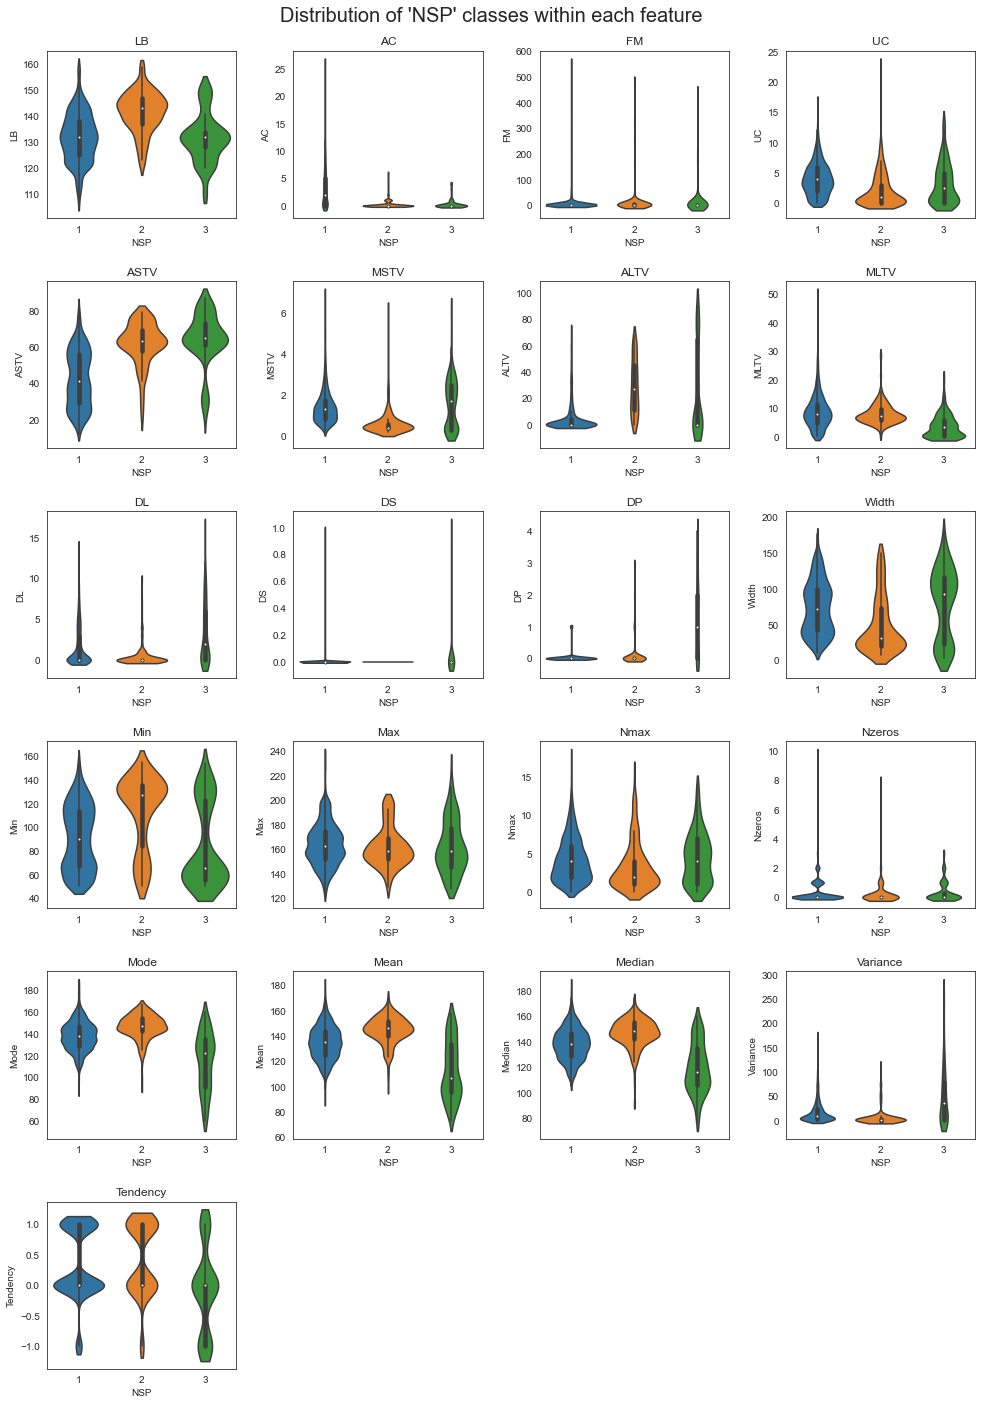

In [12]:
c = 1  # initialize plot counter

fig = plt.figure(figsize=(14,20))
fig.suptitle("Distribution of 'NSP' classes within each feature", fontsize=20)

for i in data_pp.columns[:-1]:
    plt.subplot(6, 4, c)
    plt.title(f'{i}')
    sns.violinplot(data=data, y=i, x='NSP', cut=1)
    c = c + 1

fig.tight_layout(pad=2.0)

### Create feature showing duration of instant

If we calculate the duration of each reading (or 'instant') by finding the time disatnce between the start ('s') feature and the end ('e') feature, we see in the histogram below there is a broad range of durations.

<AxesSubplot:title={'center':'Histogram of Instant Durations'}, xlabel='Duration of Instant', ylabel='Count'>

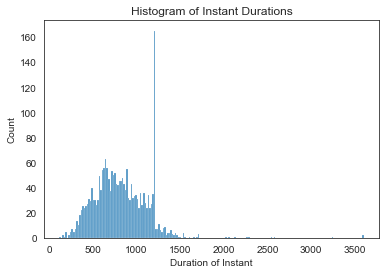

In [13]:
# calculate duration of instant
data['instant_dur'] = data['e'] - data['b']

plt.title('Histogram of Instant Durations')
plt.xlabel('Duration of Instant')
sns.histplot(data=data, x='instant_dur', bins=200)

In [14]:
from scipy.stats import mode

mode(data['instant_dur'])

ModeResult(mode=array([1199]), count=array([150]))

The histogram clearly shows a flaw in the data wherein an abnormal count of readings have a duration of exactly 1199. In order to fully understand this abnormality, the cardiotocography device would need to inspected. For our purposes we will assume it is due to the fact that the machine stops recording just before it reaches a duration of 20 hours (or 1200 minutes). 

All the records with a duration of 1199 are problematic. Though the majority of these records are probably incomplete readings, there could be actual records that _are_ complete and actually lasted for a duration of 1199. Unfortunately it is not possible to determine which records are complete and which are incomplete, so it is probably best to remove all records with this duration.

In [15]:
data = data[data['instant_dur']!=1199].reset_index(drop=True)

### Convert count-features to frequency-features

As we saw above, there is a wide range of instant durations with distant outliers. Therefore one would expect the quantity of event occurences to correlate with the duration of the reading.

In [16]:
# columns that are a COUNT of a behavior
sum_cols = data[['AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'Nmax', 'Nzeros']].columns

In [17]:
data[sum_cols].corrwith(data['instant_dur'])

AC        0.342417
FM       -0.025322
UC        0.617426
DL        0.276923
DS        0.027668
DP        0.096681
Nmax      0.085043
Nzeros   -0.035028
dtype: float64

With the exception of "FM" and “Nzeros,” all features are positively correlated with the “instant_dur” feature. Therefore, we would expect all of the features indicated as being correlated with “instant_dur” to also have a positive kurtosis and skew.

Below we see the 'instant_dur' feature has a right skew and a large positive kurtosis. The KDE plot further shows that many records are tightly congregated around a narrow range of instat durations (~500-1000 minutes), but that there are outliers that have durations reaching beyond 3500.

In [18]:
from scipy.stats import  skew, kurtosis

print(f"kurtosis: {round(kurtosis(data['instant_dur']),4)}")
print(f"skew: {round(skew(data['instant_dur']),4)}")

kurtosis: 11.3117
skew: 1.7031


<AxesSubplot:xlabel='instant_dur', ylabel='Density'>

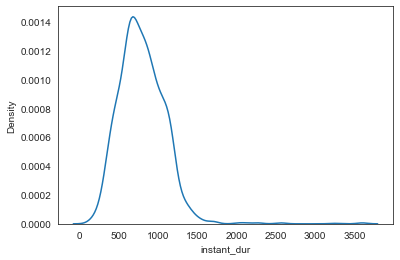

In [19]:
sns.kdeplot(data=data, x='instant_dur')

We do not want to remove the outliers of the 'instant_dur' feature as they could contain useful information. Indeed, 'instat_dur' could itself be a strong predictor of 'NSP' class. Therefore we will instead find all features that are a __count__ of an event, then divide by the duration. This will convert the data from __counts__ to __frequencies__. We should expect to see a reduction in skew and kurtosis as a result (at least in the features above we determined to be positively correlated with 'instant_dur').

In [20]:
#Calculate frequencies
for cols in sum_cols:
    data[cols + '_fq'] = (data[cols]/data['instant_dur'])*100

#Create dataframe with counts and frequencies of features
sum_cols_fq = []

for cols in sum_cols:
    sum_cols_fq.append(cols)
    sum_cols_fq.append(cols+'_fq')

sum_cols_data_scaled = data[sum_cols_fq]
sum_cols_data_scaled = pd.concat([sum_cols_data_scaled, data['NSP']], axis=1)

In [21]:
k_s = np.repeat(np.array(['Kurtosis', 'Skew']),3)
o_s_d_p = np.tile(np.array(['Original', 'Scaled', 'Pct_Diff']),2)
s_k_metrics = pd.DataFrame(index=[k_s, o_s_d_p])

for cols in sum_cols:
    unscaled_cols = sum_cols_data_scaled[cols]
    scaled_cols = sum_cols_data_scaled[cols+"_fq"]
    s_k_metrics = pd.concat([s_k_metrics, pd.Series(
        {("Kurtosis", "Original"):  kurtosis(unscaled_cols), 
        ("Kurtosis", "Scaled"):     kurtosis(scaled_cols), 
        ("Kurtosis", "Pct_Diff"):   (kurtosis(scaled_cols) - kurtosis(unscaled_cols)) / kurtosis(unscaled_cols),
        ("Skew", "Original"):       skew(unscaled_cols), 
        ("Skew", "Scaled"):         skew(scaled_cols), 
        ("Skew", "Pct_Diff"):       (skew(scaled_cols) - skew(unscaled_cols)) / skew(unscaled_cols)},
            name=cols)], axis=1)

s_k_metrics.T

Kurtosis                              Skew                     
          Original      Scaled   Pct_Diff   Original     Scaled  Pct_Diff
AC        3.385874    0.776161  -0.770765   1.696826   1.211512 -0.286013
FM      110.396276   71.318579  -0.353977   9.591336   8.226463 -0.142303
UC        1.427536   -0.582316  -1.407917   0.833020   0.103460 -0.875801
DL        2.874818    2.204859  -0.233044   1.758002   1.648267 -0.062420
DS      277.289269  297.376836   0.072443  16.711950  17.153586  0.026426
DP       18.066958   18.596870   0.029331   4.120532   4.134339  0.003351
Nmax      0.330541    4.462734  12.501311   0.860259   1.724453  1.004573
Nzeros   17.997684   15.813016  -0.121386   3.158339   3.331108  0.054703

We see above that some features (such as 'DL') exhibited a large reduction in skew and kurtosis, some (such as 'DP') were relatively unchanged, and some (such as 'Nmax') actually showed a large _increase_ in skew and kurtosis.

# Prepare Data for Modeling

## Retain Only Predictor Variables

In [22]:
feature_cols = data.drop(sum_cols, axis=1).columns
feature_cols = feature_cols.drop(['b', 'e', 'NSP', 'instant_dur'])
feature_cols

Index(['LB', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width', 'Min', 'Max', 'Mode',
       'Mean', 'Median', 'Variance', 'Tendency', 'AC_fq', 'FM_fq', 'UC_fq',
       'DL_fq', 'DS_fq', 'DP_fq', 'Nmax_fq', 'Nzeros_fq'],
      dtype='object')

## Test-Train Split

We will split the data into TRAINING and TEST sets whose percentages of records will be 70% to 30% respectively. The splitting will also ensure the balances of each class are the same in both the test set and training set.

Finally, we will normalize the X data in both sets using a Yeo-Johnson transformation.

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(copy=False)

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=531)
train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data['NSP']))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols].reset_index(drop=True)
X_train_scaled = pd.DataFrame(pt.fit_transform(X_train), columns=feature_cols)
y_train = data.loc[train_idx, 'NSP'].reset_index(drop=True)

X_test  = data.loc[test_idx, feature_cols].reset_index(drop=True)
X_test_scaled = pd.DataFrame(pt.transform(X_test), columns=feature_cols)
y_test  = data.loc[test_idx, 'NSP'].reset_index(drop=True)

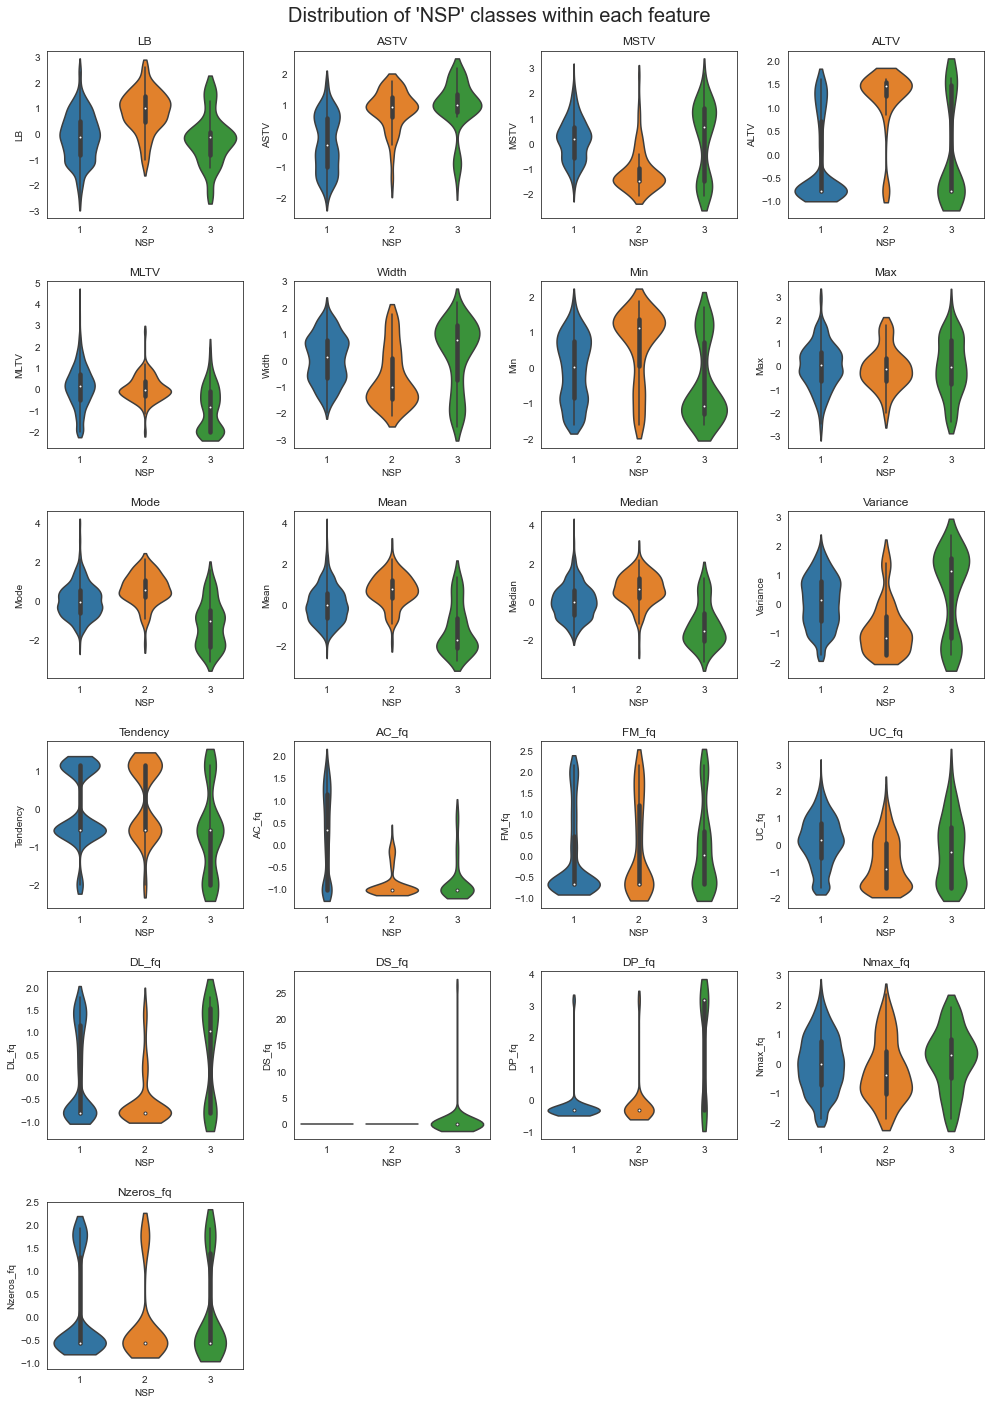

In [24]:
train_full = pd.concat([X_train_scaled, y_train], axis=1)

c = 1  # initialize plot counter

fig = plt.figure(figsize=(14,20))
fig.suptitle("Distribution of 'NSP' classes within each feature", fontsize=20)

for i in train_full.iloc[:,:-1]:
    plt.subplot(6, 4, c)
    plt.title(f'{i}')
    sns.violinplot(data=train_full, y=i, x='NSP', cut=1)
    c = c + 1

fig.tight_layout(pad=2.0)

We see above that--in comparison to the set of violin plots pre-normilization--these violin plots of the transformed features in most cases have distributions that are closer to a normal distribution.

## Balance the Classes

In order to improve the results for these classification models, it will help to balance the classes so there are an equal (or close to equal) amount of records for each class. This will ensure one class is not over-represented in model training. 

We see below that the classes are indeed unbalanaced, where NSP = 1 represents over 78% of records and NSP=3 represents only 8% of records.

In [25]:
print('Training Set Class Distribution')
print(f'{y_train.value_counts()}')
print('Test Set Class Distribution')
print(f'{y_test.value_counts()}')

Training Set Class Distribution
1    1090
2     176
3     117
Name: NSP, dtype: int64
Test Set Class Distribution
1    468
2     75
3     50
Name: NSP, dtype: int64


In order to balance classes, one can oversample (in order to boost the quantity of records for the minority classes), undersample (in order to reduce the quantity of records in the majority class), or a combination of both in which the minority classes are oversampled then all classes are reduced by using an undersampling method. 

For our purposes, we will only use oversampling methods and combination methods. Given that there are not many records in the minority classes, it would be more beneficial to boost the quantities of those classes, rather than to severly reduce the quantity of records in the majority class.

The oversampling methods used are: SMOTE and ADASYN
The combination methods used are: SMOTE with Edited Nearest Neighbors (ENN) and SMOTE with Tomek's Links (Tomek)

In [118]:
# Not doing undersampling because we don't have a lot of samples to begin with

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek

X_train_SMOTE, y_train_SMOTE = SMOTE(random_state=531).fit_resample(X_train_scaled, y_train)
X_train_ADASYN, y_train_ADASYN = ADASYN(random_state=531).fit_resample(X_train_scaled, y_train)
X_train_SMOTEENN, y_train_SMOTEENN = SMOTEENN(random_state=531).fit_resample(X_train_scaled, y_train)
X_train_SMOTETomek, y_train_SMOTETomek = SMOTETomek(random_state=531).fit_resample(X_train_scaled, y_train)

sampler_labels = ['SMOTE', 'ADASYN', 'SMOTE-ENN', 'SMOTE-Tomek']
Xtrains = [X_train_SMOTE, X_train_ADASYN, X_train_SMOTEENN, X_train_SMOTETomek]
ytrains = [y_train_SMOTE, y_train_ADASYN, y_train_SMOTEENN, y_train_SMOTETomek]

We see below that after utilizing these sampling methods, the calsses are much more in balance than before.

In [27]:
class_balance = pd.DataFrame()

for i,n in zip(ytrains,sampler_labels):
    class_balance = pd.concat([class_balance, pd.Series(i.value_counts(), name=n)], axis=1)

class_balance

,SMOTE,ADASYN,SMOTE-ENN,SMOTE-Tomek
1,1090,1090,944,1089
2,1090,1067,1056,1088
3,1090,1073,1080,1089


## Define error metrics

Below we have defined the four error metrics we will examine for every model. However, the most important error metric for our purposes is RECALL. We use recall because it is a metric that 

In [29]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def measure_error(y_true, y_pred, label):
    # Temporarily code classes 2 & 3 as 2 
    # (i.e. 'Suspect' & 'Pathological' will be grouped together as a Positive class)
    y_true_c1 = y_true.replace([2,3],2)
    y_pred_c1 = y_pred.replace([2,3],2)
    return pd.Series({'accuracy':accuracy_score(y_true_c1, y_pred_c1),
                      'precision': precision_score(y_true_c1, y_pred_c1, pos_label=2),
                      'recall': recall_score(y_true_c1, y_pred_c1, pos_label=2),
                      'f1': f1_score(y_true_c1, y_pred_c1, pos_label=2)},
                      name=label)

# Model 1 - Logistic Regression

## Define Logistic Regression Models w/ L1 & L2 Regularization

In [30]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

lr = LogisticRegression(solver='liblinear')

lr_l1 = LogisticRegressionCV(
    Cs=10, cv=4, penalty='l1',
    max_iter=1000, solver='liblinear', 
    scoring='recall_macro', n_jobs=-1)

lr_l2 = LogisticRegressionCV(
    Cs=10, cv=4, penalty='l2', 
    max_iter=1000, solver='liblinear', 
    scoring='recall_macro', n_jobs=-1)

## 1a - Evaluate Models w/ Classes Imbalanced

### Fit Models

In [58]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['Lr', 'L1', 'L2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.fit(X_train_scaled, y_train).coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [1,2,3]], 
                                 codes=[[0,0,0], [0,1,2]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1).set_index(feature_cols)

In [59]:
for class_num in coefficients.columns:
    print(class_num, len(coefficients[coefficients[class_num] != 0]), 'coefficients')

('Lr', 1) 21 coefficients
('Lr', 2) 21 coefficients
('Lr', 3) 21 coefficients
('L1', 1) 19 coefficients
('L1', 2) 16 coefficients
('L1', 3) 21 coefficients
('L2', 1) 21 coefficients
('L2', 2) 21 coefficients
('L2', 3) 21 coefficients


### Predict and Score

In [60]:
y_pred = list()

coeff_labels = ['Lr', 'L1', 'L2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test_scaled), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)

In [61]:
error_measures = pd.DataFrame()

for lab in coeff_labels:
    error_measures = pd.concat([error_measures, measure_error(y_test, y_pred[lab], lab)], axis=1)
    
error_measures.T

,accuracy,precision,recall,f1
Lr,0.912310,0.834862,0.728,0.777778
L1,0.915683,0.857143,0.720,0.782609
L2,0.910624,0.750000,0.864,0.802974


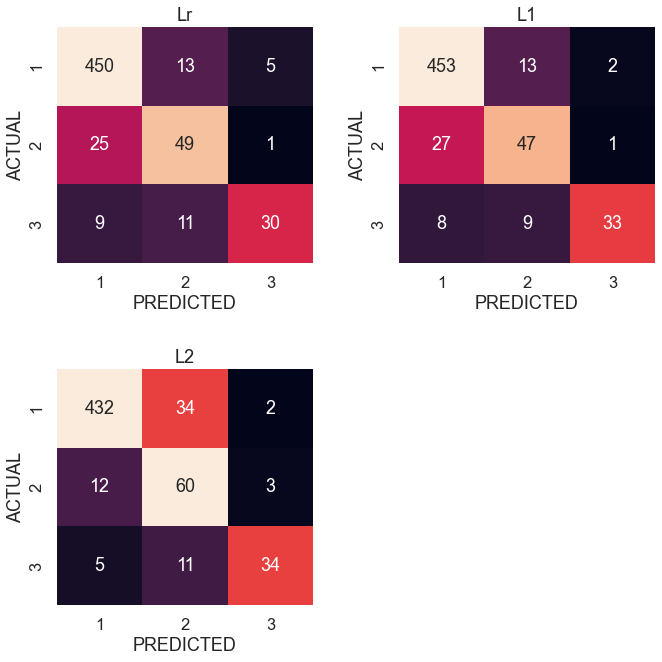

In [62]:
cm = dict()

for lab in coeff_labels:
    cm[lab] = confusion_matrix(y_test, y_pred[lab])

sns.set_context('talk')

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, vmax=55, annot=True, fmt='d',
        cbar=False, xticklabels=[1,2,3], yticklabels=[1,2,3])
    ax.set(title=lab)
    ax.set_xlabel('PREDICTED')
    ax.set_ylabel('ACTUAL')
    
plt.tight_layout(pad=2.0)

Confusion matrix shows class 1 is frequently misclassed as class 0. Need to control for the imbalance in classes.

### Evaluate Coefficients

In [37]:
"""coefficients_L1 = coefficients['L1']
coefficients_L1['importances'] = abs(coefficients_L1[1]) + abs(coefficients_L1[2]) + abs(coefficients_L1[3])
coefficients_L1 = coefficients_L1.sort_values(by='importances', ascending=False)
coefficients_L1 = coefficients_L1.reset_index().reset_index()
coefficients_L1 = coefficients_L1.rename(columns={'level_0':'feature_count', 'index':'Feature'})
coefficients_L1"""

"coefficients_L1 = coefficients['L1']\ncoefficients_L1['importances'] = abs(coefficients_L1[1]) + abs(coefficients_L1[2]) + abs(coefficients_L1[3])\ncoefficients_L1 = coefficients_L1.sort_values(by='importances', ascending=False)\ncoefficients_L1 = coefficients_L1.reset_index().reset_index()\ncoefficients_L1 = coefficients_L1.rename(columns={'level_0':'feature_count', 'index':'Feature'})\ncoefficients_L1"

In [38]:
coefficients_L2 = coefficients['L2']
coefficients_L2['importances'] = abs(coefficients_L2[1]) + abs(coefficients_L2[2]) + abs(coefficients_L2[3])
coefficients_L2 = coefficients_L2.sort_values(by='importances', ascending=False)
coefficients_L2 = coefficients_L2.reset_index().reset_index()
coefficients_L2 = coefficients_L2.rename(columns={'level_0':'feature_count', 'index':'Feature'})
coefficients_L2

C:\Users\14126\AppData\Local\Temp/ipykernel_23368/1789929029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coefficients_L2['importances'] = abs(coefficients_L2[1]) + abs(coefficients_L2[2]) + abs(coefficients_L2[3])


,feature_count,Feature,1,2,3,importances
0,0,Median,0.066729,0.035120,-4.395496,4.497346
1,1,Width,0.023819,-0.026148,-3.386400,3.436367
2,2,Min,0.004500,0.025920,-3.034893,3.065313
3,3,Max,-0.133303,0.010851,2.321769,2.465923
4,4,LB,-0.210207,0.057330,2.167847,2.435383
5,5,ASTV,-0.342208,0.058631,1.993994,2.394833
6,6,AC_fq,0.357302,-0.075160,-1.379646,1.812108
7,7,DL_fq,0.012490,-0.016007,-1.373307,1.401804
8,8,UC_fq,0.214398,-0.050757,-0.979690,1.244846
9,9,DP_fq,-0.416069,0.012104,0.568681,0.996854


<AxesSubplot:xlabel='feature_count', ylabel='importances'>

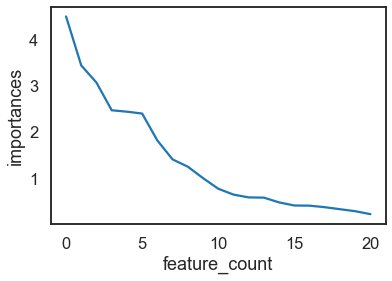

In [39]:
sns.lineplot(data=coefficients_L2, x='feature_count', y='importances')

## 1b - Evaluate L1 Model with Balanced Classes

### Fit Models Based on Oversampling & Undersampling Methods

In [63]:
y_test_pred = pd.DataFrame()
y_train_pred = pd.DataFrame()
coefficients = list()

for lab, Xts, yts in zip(sampler_labels, Xtrains, ytrains):
    loop_start=time.time()
    #lr_l1.fit(Xts, yts)
    #y_test_pred = pd.concat([y_test_pred, pd.Series(lr_l1.predict(X_test_scaled), name=lab)], axis=1)
    #y_train_pred = pd.concat([y_train_pred, pd.Series(lr_l1.predict(Xts), name=lab)], axis=1)
    #coeffs = lr_l1.coef_
    lr_l2.fit(Xts, yts)
    y_test_pred = pd.concat([y_test_pred, pd.Series(lr_l2.predict(X_test_scaled), name=lab)], axis=1)
    y_train_pred = pd.concat([y_train_pred, pd.Series(lr_l2.predict(Xts), name=lab)], axis=1)
    coeffs = lr_l2.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [1,2,3]], 
                                 codes=[[0,0,0], [0,1,2]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))
    end = time.time()
    print(f"{lab} time elapsed: {round(end - loop_start, 1)} seconds")

coefficients = pd.concat(coefficients, axis=1).set_index(feature_cols)

SMOTE time elapsed: 0.5 seconds
ADASYN time elapsed: 0.5 seconds
SMOTE-ENN time elapsed: 0.5 seconds
SMOTE-Tomek time elapsed: 0.5 seconds


### Predict and Score

In [64]:
error_measures = pd.DataFrame()

for lab, yts in zip(sampler_labels, ytrains):
    error_measures = pd.concat([error_measures, measure_error(y_test, y_test_pred[lab], lab)], axis=1)
    
error_measures.T

,accuracy,precision,recall,f1
SMOTE,0.888702,0.666667,0.944,0.781457
ADASYN,0.888702,0.672515,0.920,0.777027
SMOTE-ENN,0.870152,0.627660,0.944,0.753994
SMOTE-Tomek,0.888702,0.666667,0.944,0.781457


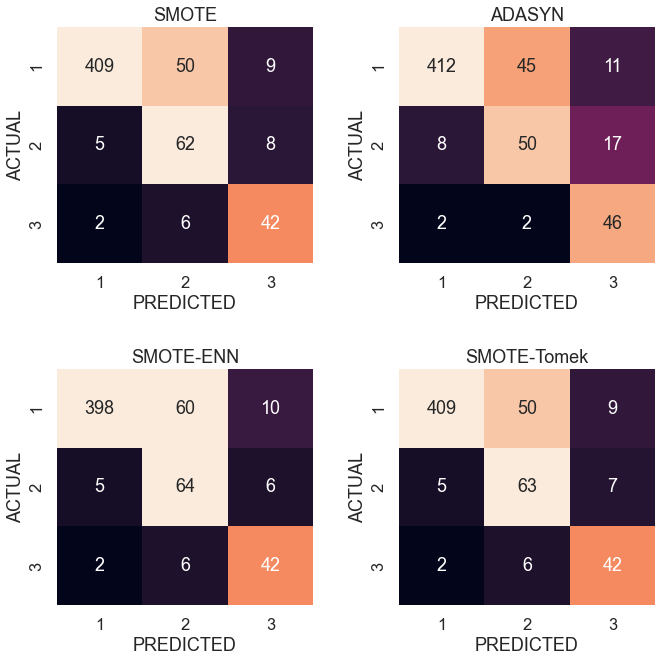

In [65]:
cm = dict()

for lab in sampler_labels:
    cm[lab] = confusion_matrix(y_test, y_test_pred[lab])

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10, 10)

for ax,lab in zip(axList, sampler_labels):
    sns.heatmap(cm[lab], ax=ax, vmax=55, annot=True, fmt='d',
        cbar=False, xticklabels=[1,2,3], yticklabels=[1,2,3])
    ax.set(title=lab)
    ax.set_xlabel('PREDICTED')
    ax.set_ylabel('ACTUAL')
    
plt.tight_layout(pad=2.0)

### Evaluate Coefficients

In [66]:
# Smote-Tomek had the fewest false negatives
coefficients_SMTk = coefficients['SMOTE-Tomek']
coefficients_SMTk['importances'] = abs(coefficients_SMTk[1]) + abs(coefficients_SMTk[2]) + abs(coefficients_SMTk[3])
coefficients_SMTk = coefficients_SMTk.sort_values(by='importances', ascending=False)
coefficients_SMTk= coefficients_SMTk.reset_index().reset_index()
coefficients_SMTk = coefficients_SMTk.rename(columns={'level_0':'feature_count'})
coefficients_SMTk

C:\Users\14126\AppData\Local\Temp/ipykernel_23368/4033576427.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coefficients_SMTk['importances'] = abs(coefficients_SMTk[1]) + abs(coefficients_SMTk[2]) + abs(coefficients_SMTk[3])


,feature_count,index,1,2,3,importances
0,0,DS_fq,-1.192252,-0.034208,7.159024,8.385485
1,1,Median,1.577622,0.239656,-5.734045,7.551322
2,2,Width,2.761491,-0.011562,-3.131831,5.904884
3,3,AC_fq,2.322563,-0.381327,-2.742526,5.446416
4,4,Max,-2.208445,0.161488,2.626286,4.996219
5,5,Min,1.811927,0.098951,-3.016497,4.927375
6,6,ASTV,-1.655679,-0.131798,2.525061,4.312538
7,7,Mean,-1.553864,0.211326,0.851646,2.616835
8,8,ALTV,-0.745711,0.487467,-1.154403,2.387581
9,9,LB,-0.243776,0.067609,2.060805,2.372190


<AxesSubplot:xlabel='feature_count', ylabel='importances'>

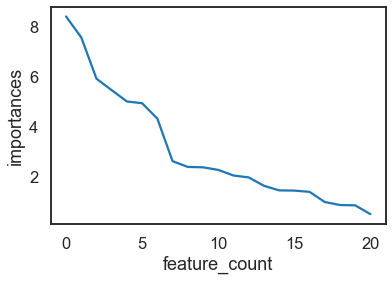

In [67]:
sns.lineplot(data=coefficients_SMTk, x='feature_count', y='importances')

## 1c - Add polynomial features (degree 2)

In [45]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, include_bias=False)

X_train_poly = pd.DataFrame(poly.fit_transform(X_train), columns=poly.get_feature_names_out())
X_test_poly = pd.DataFrame(poly.fit_transform(X_test), columns=poly.get_feature_names_out())

feature_cols_poly = poly.get_feature_names_out()

X_train_scaled_poly = pd.DataFrame(pt.fit_transform(X_train_poly), columns=feature_cols_poly)
X_test_scaled_poly = pd.DataFrame(pt.transform(X_test_poly), columns=feature_cols_poly)


c:\Users\14126\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [46]:
X_test_scaled_poly.head()

,LB,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Mode,Mean,...,DS_fq^2,DS_fq DP_fq,DS_fq Nmax_fq,DS_fq Nzeros_fq,DP_fq^2,DP_fq Nmax_fq,DP_fq Nzeros_fq,Nmax_fq^2,Nmax_fq Nzeros_fq,Nzeros_fq^2
0,-1.128564,-1.481854,0.661813,-0.781030,1.037903,-0.789513,0.439822,-1.299797,-0.845168,-0.729992,...,-0.038056,-0.0269,-0.038056,-0.038056,-0.313278,-0.311903,-0.185487,-1.244903,-0.538148,-0.537756
1,-1.836877,-1.969620,1.185796,-0.781030,-0.318711,0.654382,-0.524857,0.376433,-1.418383,-1.528060,...,-0.038056,-0.0269,-0.038056,-0.038056,3.285244,3.267386,5.392864,0.763572,2.064396,2.039864
2,-0.723826,0.114825,-0.764344,-0.781030,-0.158818,-0.789513,0.845235,-0.429129,-0.374793,-0.042193,...,-0.038056,-0.0269,-0.038056,-0.038056,-0.313278,-0.311903,-0.185487,-0.550678,-0.538148,-0.537756
3,-0.015557,-0.899222,0.204047,-0.781030,0.886138,-0.105169,0.375360,0.045985,0.075238,0.230359,...,-0.038056,-0.0269,-0.038056,-0.038056,-0.313278,-0.311903,-0.185487,-0.785709,-0.538148,-0.537756
4,1.097386,0.784426,-1.467325,1.140876,-0.007621,-0.928511,0.995416,-0.367419,0.562315,0.662260,...,-0.038056,-0.0269,-0.038056,-0.038056,-0.313278,-0.311903,-0.185487,-1.244903,-0.538148,-0.537756


In [218]:
"""X_train_poly_SMOTE, y_train_poly_SMOTE = SMOTE(random_state=531).fit_resample(X_train_scaled_poly, y_train)
X_train_poly_Tomek, y_train_poly_Tomek = TomekLinks().fit_resample(X_train_scaled_poly, y_train)
X_train_poly_ENN, y_train_poly_ENN = EditedNearestNeighbours().fit_resample(X_train_scaled_poly, y_train)
X_train_poly_SMOTEENN, y_train_poly_SMOTEENN = SMOTEENN(random_state=531).fit_resample(X_train_scaled_poly, y_train)
X_train_poly_SMOTETomek, y_train_poly_SMOTETomek = SMOTETomek(random_state=531).fit_resample(X_train_scaled_poly, y_train)
X_train_poly_ADASYN, y_train_poly_ADASYN = ADASYN(random_state=531).fit_resample(X_train_scaled_poly, y_train)

X_trains_poly = [X_train_poly_SMOTE, X_train_poly_ADASYN, X_train_poly_Tomek, 
                 X_train_poly_ENN, X_train_poly_SMOTEENN, X_train_poly_SMOTETomek]
y_trains_poly = [y_train_poly_SMOTE, y_train_poly_ADASYN, y_train_poly_Tomek, 
                 y_train_poly_ENN, y_train_poly_SMOTEENN, y_train_poly_SMOTETomek]"""

In [47]:
X_train_poly_SMOTETk, y_train_poly_SMOTETk = SMOTETomek(random_state=531).fit_resample(X_train_scaled_poly, y_train)
X_train_poly_ADASYN, y_train_poly_ADASYN = ADASYN(random_state=531).fit_resample(X_train_scaled_poly, y_train)

X_trains_poly = [X_train_poly_ADASYN, X_train_poly_SMOTETk]
y_trains_poly = [y_train_poly_ADASYN, y_train_poly_SMOTETk]

In [48]:
# WARNING!!! Takes 60+ minutes to run
# Only using two methods, because it takes too long to run otherwise
import time
from joblib import Parallel, delayed
import multiprocessing

y_test_pred = list()
coefficients = list()
Xtrains_poly_adasyn_smotetk = [X_train_poly_ADASYN, X_train_poly_SMOTETk]
ytrains_poly_adasyn_smotetk = [y_train_poly_ADASYN, y_train_poly_SMOTETk]

def poly_log (lab, Xts, yts):
    loop_start=time.time()

    lr_l1.fit(Xts, yts)
    y_test_pred.append(pd.Series(lr_l1.predict(X_test_scaled_poly), name=lab))
    y_train_pred.append(pd.Series(lr_l1.predict(Xts), name=lab))
    coeffs = lr_l1.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1]], 
                                 codes=[[0,0,0], [0,1,2]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))
    end = time.time()
    print(f"{lab} time elapsed: {round(end - loop_start, 1)} seconds")

start = time.time()
    
#num_cores = multiprocessing.cpu_count()
Parallel(n_jobs=-1)(delayed(poly_log)(lab, Xts, yts) 
                           for lab, Xts, yts in zip(['ADASYN', 'SMOTE-ENN'], Xtrains_poly_adasyn_smotetk, ytrains_poly_adasyn_smotetk))

end = time.time()   
print(f"Total time elapsed: {(end - start)/60} minutes")

In [ ]:
coefficients

[]

In [ ]:
"""# WARNING!!! Takes 30+ minutes to run
# Only using undersampling methods, because it takes too long to run otherwise
import time

start = time.time()

y_test_pred = list()
y_train_pred = list()
coefficients = list()

Xtrains_poly_smote_enn = [X_train_poly_Tomek, X_train_poly_ENN]
ytrains = [y_train_Tomek, y_train_ENN]

for lab, Xts, yts in zip(['SMOTE', 'ENN'], Xtrains_smote_enn, ytrains_t_enn):
    loop_Start=time.time()
    lr_l1.fit(Xts, yts)
    y_test_pred.append(pd.Series(lr_l1.predict(X_test_scaled_poly), name=lab))
    y_train_pred.append(pd.Series(lr_l1.predict(Xts), name=lab))
    coeffs = lr_l1.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2]], 
                                 codes=[[0,0,0], [0,1,2]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))
    end = time.time()
    print(f"{lab} time elapsed: {round(end - loop_start, 1)} seconds")
    
print(f"{lab} time elapsed: {(end - start)/60} minutes")"""

In [ ]:
feature_cols_poly = pd.Series(feature_cols_poly)

In [ ]:
coefficients = pd.concat(coefficients, axis=1).set_index(feature_cols_poly)

Tomek                            ENN                 
                0          1         2         0           1    2
x0      -3.375259   2.731186  0.000000  0.000000    2.328159  0.0
x1      -3.590866   2.875806  0.000000  0.000000    1.567477  0.0
x2       0.000000  23.645393  1.234668 -3.146521   18.733426  0.0
x3       0.000000   0.000000  0.000000  0.000000 -130.112414  0.0
x4      -2.126034   3.361432  3.631773  0.000000    0.000000  0.0
...           ...        ...       ...       ...         ...  ...
x19 x20  0.000000   0.000000  0.000000  0.000000    0.000000  0.0
x19 x21  0.000000   0.000000  0.000000  0.000000    0.000000  0.0
x20^2    2.433979   0.000000  0.000000  1.186743  -13.477000  0.0
x20 x21  0.000000   0.000000  0.000000  0.000000    0.000000  0.0
x21^2   -6.706963  10.000839  0.000000  0.000000    0.000000  0.0

[275 rows x 6 columns]

In [ ]:
y_test_pred = pd.concat(y_test_pred, axis=1)
y_train_pred = pd.concat(y_train_pred, axis=1)

In [ ]:
for class_num in coefficients.columns:
    print(class_num, len(coefficients[coefficients[class_num] != 0]), 'coefficients')

('Tomek', 0) 85 coefficients
('Tomek', 1) 76 coefficients
('Tomek', 2) 69 coefficients
('ENN', 0) 62 coefficients
('ENN', 1) 69 coefficients
('ENN', 2) 46 coefficients


In [ ]:
error_measures = pd.DataFrame()

for lab, yts in zip(['ADASYN', 'SMOTE-ENN'], ytrains):
    error_measures = pd.concat([error_measures, measure_error(y_test, y_test_pred[lab], lab+'_test')], axis=1)
    
error_measures

,Tomek_train,Tomek_test,ENN_train,ENN_test
accuracy,0.970568,0.898119,0.997585,0.890282
precision,0.961638,0.835348,0.995293,0.839046
recall,0.938508,0.779919,0.990515,0.760363
f1,0.949702,0.792421,0.992882,0.766509


In [ ]:
cm = dict()

for lab in ['Tomek', 'ENN']:
    cm[lab] = confusion_matrix(y_test, y_test_pred[lab])

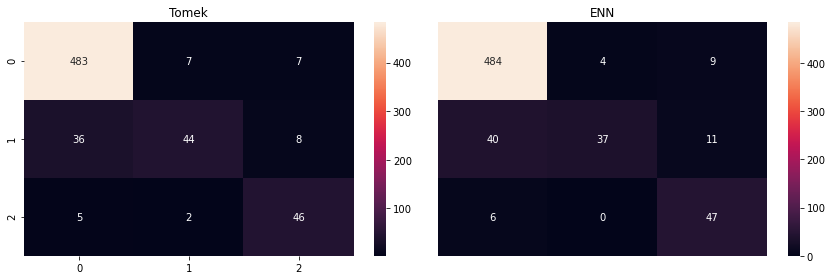

In [ ]:
fig, axList = plt.subplots(nrows=1, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10, 5)

for ax,lab in zip(axList, ['ADASYN', 'SMOTE-ENN']):
    sns.heatmap(cm[lab], ax=ax, vmax=55, annot=True, fmt='d', cbar=False)
    ax.set(title=lab)
    ax.set_xlabel('PREDICTED')
    ax.set_ylabel('ACTUAL')
    
plt.tight_layout()

# Model 2 - Decision Tree

In [68]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier(random_state=531)

## 2a - Base Model w/ Balanced Classes

In [69]:
y_test_pred = pd.DataFrame()
tree_shape = pd.DataFrame(columns=['sampler', 'nodes', 'depth'])

for lab, Xts, yts in zip(sampler_labels, Xtrains, ytrains):
    dt.fit(Xts, yts)
    tree_shape.loc[len(tree_shape.index)] = [lab, dt.tree_.node_count, 
        dt.tree_.max_depth] 
    y_test_pred[lab] = pd.Series(dt.predict(X_test_scaled))

tree_shape

,sampler,nodes,depth
0,SMOTE,219,15
1,ADASYN,277,26
2,SMOTE-ENN,163,18
3,SMOTE-Tomek,211,15


In [70]:
error_measures = pd.DataFrame()

for lab, yts in zip(sampler_labels, ytrains):
    error_measures = pd.concat([error_measures, 
              measure_error(y_test, y_test_pred[lab], lab)], axis=1)
    
error_measures.T

,accuracy,precision,recall,f1
SMOTE,0.927487,0.825397,0.832,0.828685
ADASYN,0.907251,0.769231,0.800,0.784314
SMOTE-ENN,0.880270,0.673077,0.840,0.747331
SMOTE-Tomek,0.935919,0.853659,0.840,0.846774


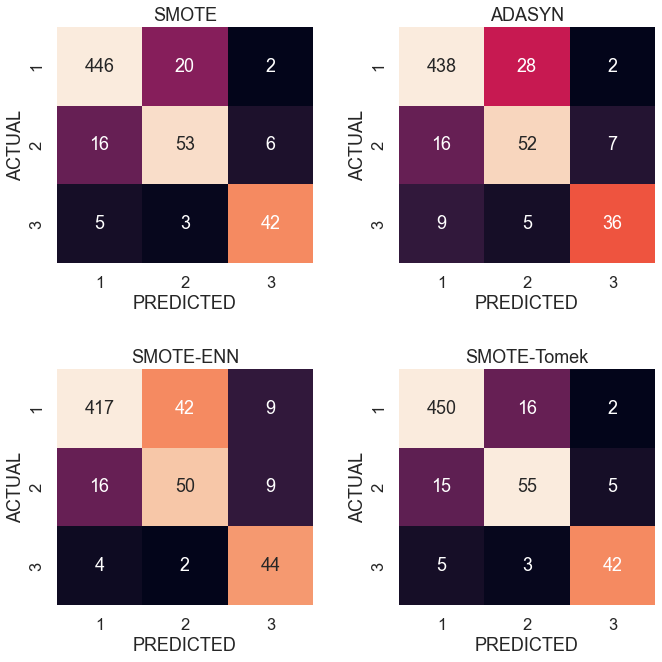

In [71]:
cm = dict()

for lab in sampler_labels:
    cm[lab] = confusion_matrix(y_test, y_test_pred[lab])

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10, 10)

for ax,lab in zip(axList, sampler_labels):
    sns.heatmap(cm[lab], ax=ax, vmax=55, annot=True, fmt='d',
        cbar=False, xticklabels=[1,2,3], yticklabels=[1,2,3])
    ax.set(title=lab)
    ax.set_xlabel('PREDICTED')
    ax.set_ylabel('ACTUAL')
    
plt.tight_layout(pad=2.0)

## 2b - Add GridSearch for max_depth and max_features

In [72]:
param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=531),
                  param_grid=param_grid,
                  scoring='recall_macro',
                  n_jobs=-1)

In [73]:
y_test_pred = pd.DataFrame()
importances_dt = pd.DataFrame()
tree_shape = pd.DataFrame(columns=['sampler', 'nodes', 'depth'])

for lab, Xts, yts in zip(sampler_labels, Xtrains, ytrains):
    GR = GR.fit(Xts, yts)
    y_test_pred[lab] = pd.Series(GR.predict(X_test_scaled), name=lab)
    importances_dt[lab] = pd.Series(GR.best_estimator_.feature_importances_)
    tree_shape.loc[len(tree_shape.index)] = [lab, GR.best_estimator_.tree_.node_count, 
        GR.best_estimator_.tree_.max_depth] 
    
importances_dt = importances_dt.set_index(feature_cols)

tree_shape

,sampler,nodes,depth
0,SMOTE,233,15
1,ADASYN,247,13
2,SMOTE-ENN,161,15
3,SMOTE-Tomek,221,13


In [74]:
error_measures = pd.DataFrame()

for lab, yts in zip(sampler_labels, ytrains):
    error_measures = pd.concat([error_measures, 
              measure_error(y_test, y_test_pred[lab], lab)], axis=1)
    
error_measures.T

,accuracy,precision,recall,f1
SMOTE,0.913997,0.760563,0.864,0.808989
ADASYN,0.920742,0.782609,0.864,0.821293
SMOTE-ENN,0.888702,0.680982,0.888,0.770833
SMOTE-Tomek,0.919056,0.773050,0.872,0.819549


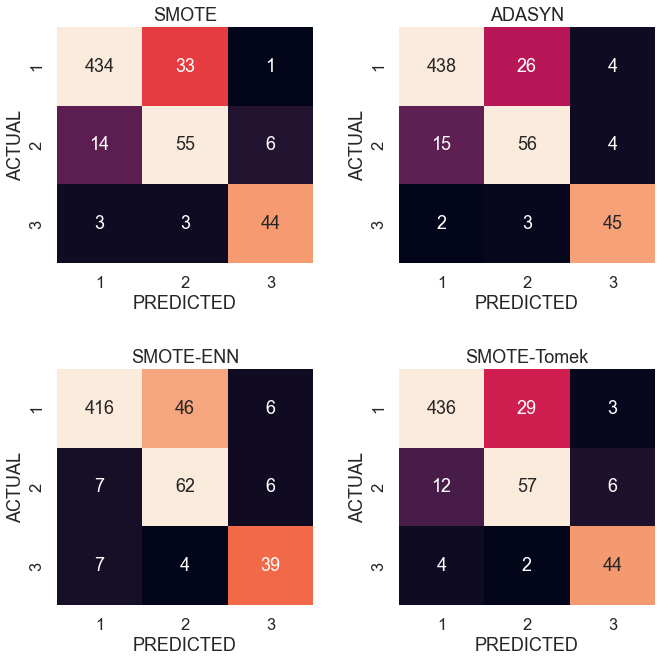

In [75]:
cm = dict()

for lab in sampler_labels:
    cm[lab] = confusion_matrix(y_test, y_test_pred[lab])
    
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10, 10)

for ax,lab in zip(axList, sampler_labels):
    sns.heatmap(cm[lab], ax=ax, vmax=55, annot=True, fmt='d',
        cbar=False, xticklabels=[1,2,3], yticklabels=[1,2,3])
    ax.set(title=lab)
    ax.set_xlabel('PREDICTED')
    ax.set_ylabel('ACTUAL')
    
plt.tight_layout(pad=2.0)

In [77]:
importances_dt_sorted = pd.DataFrame()

for cols in sampler_labels:
    importances_dt_sorted[cols] = pd.Series(importances_dt[cols].
            sort_values(ascending=False, ignore_index=True), name=cols)
            
importances_dt_sorted.reset_index(inplace=True)
importances_dt_sorted.rename(columns={'index':'feature_count'}, inplace=True)


In [78]:
importances_dt_SMOTEENN = pd.DataFrame(importances_dt['SMOTE-ENN']).sort_values(by='SMOTE-ENN', ascending=False)
importances_dt_SMOTEENN.reset_index(inplace=True)
importances_dt_SMOTEENN.reset_index(inplace=True)
importances_dt_SMOTEENN.rename(columns={'level_0':'feature_count', 'SMOTE-ENN':'feature_importance'}, inplace=True)
importances_dt_SMOTEENN

,feature_count,index,feature_importance
0,0,ALTV,0.317009
1,1,Median,0.225420
2,2,ASTV,0.139338
3,3,DP_fq,0.083199
4,4,AC_fq,0.059798
5,5,FM_fq,0.034318
6,6,LB,0.026878
7,7,MSTV,0.024467
8,8,Tendency,0.022867
9,9,DL_fq,0.020183


<AxesSubplot:xlabel='feature_count', ylabel='feature_importance'>

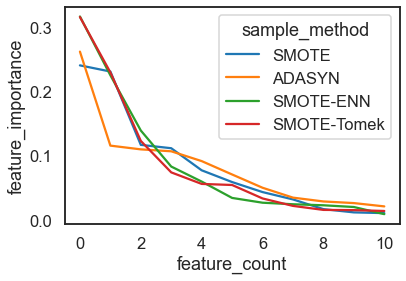

In [81]:
import seaborn as sns
importances_trim = importances_dt_sorted.iloc[:11, :]
importances_dt_sorted_melt = importances_trim.melt('feature_count', 
                                                   var_name='sample_method',  value_name='feature_importance')
sns.lineplot(data=importances_dt_sorted_melt, x='feature_count', y='feature_importance', hue='sample_method')

In [82]:
dt = DecisionTreeClassifier(random_state=531, max_depth=17, max_features=19)
dt = dt.fit(X_train_SMOTEENN, y_train_SMOTEENN)
y_test_pred = dt.predict(X_test)

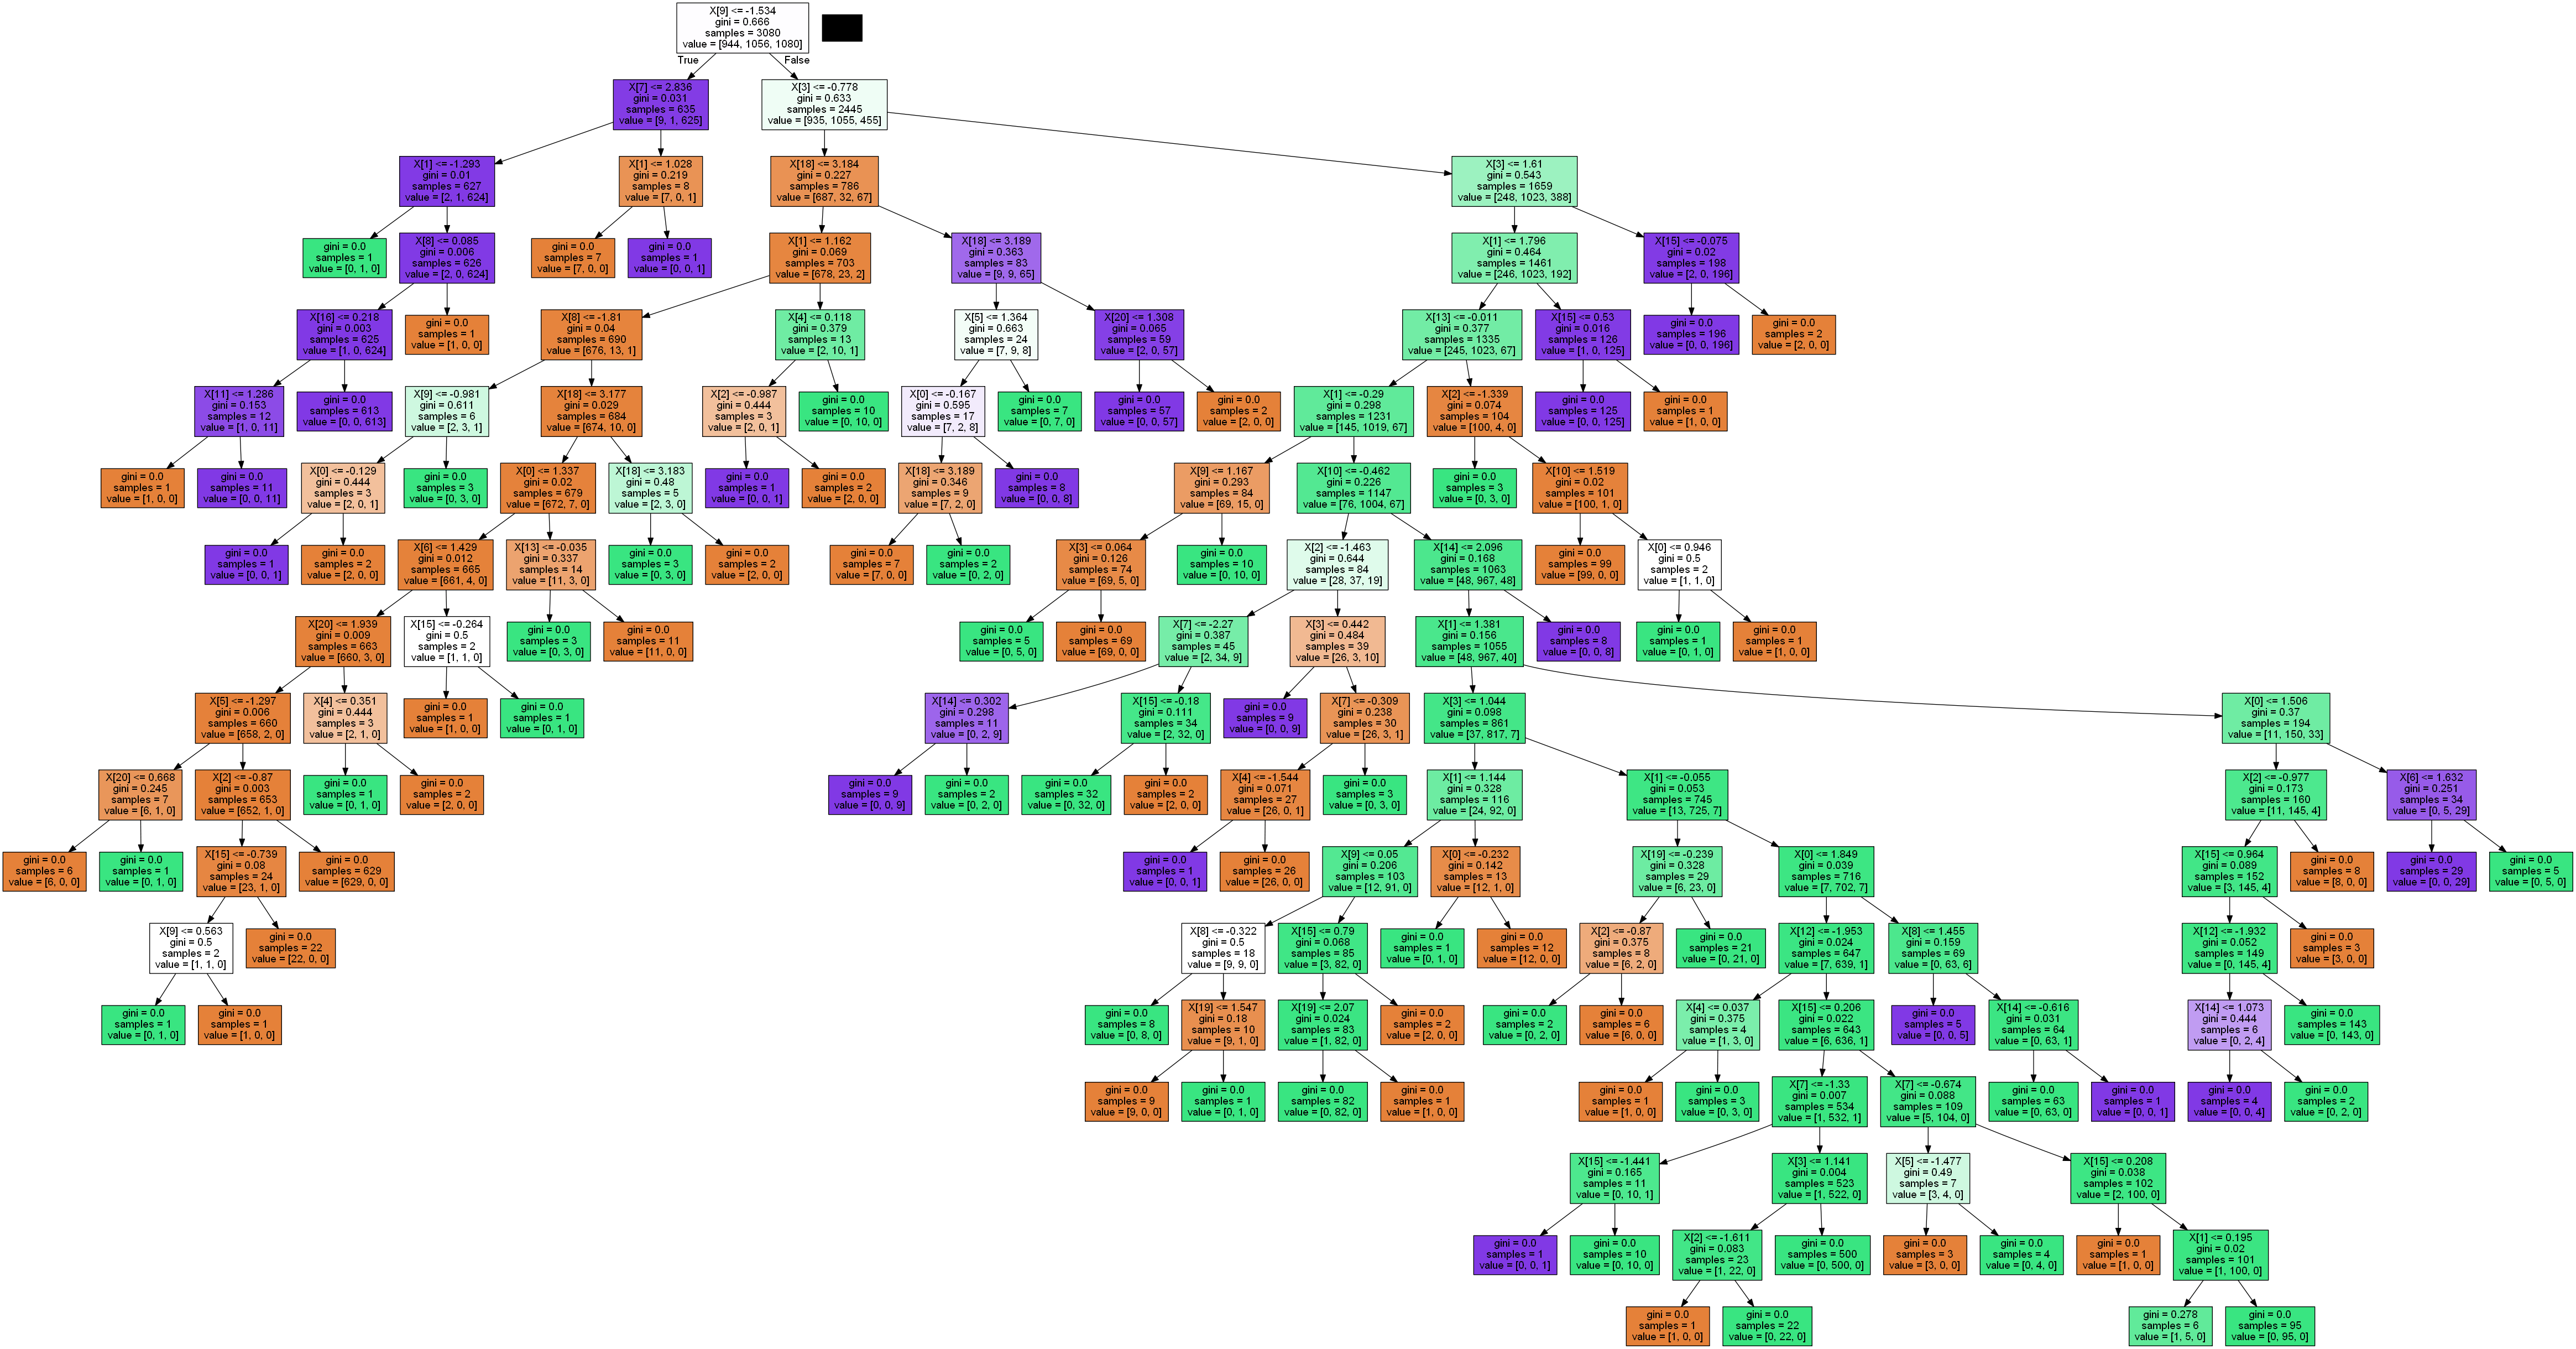

In [83]:
from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

# Create an output destination for the file
dot_data = StringIO()

export_graphviz(dt, out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# View the tree image
filename = 'fetal_toco_tree.png'
graph.write_png(filename)
Image(filename=filename) 

## 2c - Rerun with only most important features

In [84]:
param_grid = {'max_depth':range(1, 18+1, 2),
              'max_features': range(1, 6+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=531),
                  param_grid=param_grid,
                  scoring='recall_macro',
                  n_jobs=-1)

In [85]:
y_test_pred = pd.DataFrame()
importances_dt = pd.DataFrame()
tree_shape = pd.DataFrame(columns=['sampler', 'nodes', 'depth'])

for lab, Xts, yts in zip(sampler_labels, Xtrains, ytrains):
    GR = GR.fit(Xts, yts)
    y_test_pred[lab] = pd.Series(GR.predict(X_test_scaled), name=lab)
    importances_dt[lab] = pd.Series(GR.best_estimator_.feature_importances_, name=lab)
    tree_shape.loc[len(tree_shape.index)] = [lab, GR.best_estimator_.tree_.node_count, 
        GR.best_estimator_.tree_.max_depth] 
    #print([lab], dict(nodes = GR.best_estimator_.tree_.node_count, depth=GR.best_estimator_.tree_.max_depth, params=GR.best_params_))
    
importances_dt = importances_dt.set_index(feature_cols)

tree_shape

,sampler,nodes,depth
0,SMOTE,315,15
1,ADASYN,331,17
2,SMOTE-ENN,251,13
3,SMOTE-Tomek,329,15


In [86]:
error_measures = pd.DataFrame()

for lab, yts in zip(sampler_labels, ytrains):
    error_measures = pd.concat([error_measures, 
              measure_error(y_test, y_test_pred[lab], lab)], axis=1)
    
error_measures.T

,accuracy,precision,recall,f1
SMOTE,0.935919,0.804196,0.920,0.858209
ADASYN,0.919056,0.781022,0.856,0.816794
SMOTE-ENN,0.895447,0.695652,0.896,0.783217
SMOTE-Tomek,0.925801,0.791367,0.880,0.833333


In [87]:
importances_dt[['SMOTE']].sort_values(by='SMOTE', ascending=False).iloc[0:6]

,SMOTE
Median,0.263343
MSTV,0.178780
ASTV,0.117454
ALTV,0.085254
AC_fq,0.064504
DP_fq,0.061370


## 2d - Try with Polynomial features

In [64]:
param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, 4+1)} #b/c we don't want more features than above

GR = GridSearchCV(DecisionTreeClassifier(random_state=531),
                  param_grid=param_grid,
                  scoring='recall_macro',
                  n_jobs=-1)

In [ ]:
y_test_pred = pd.DataFrame()
importances_dt_poly = pd.DataFrame()
tree_shape = pd.DataFrame(columns=['sampler', 'nodes', 'depth'])

for lab, Xts, yts in zip(sampler_labels, X_trains_poly, y_trains_poly):
    GR = GR.fit(Xts, yts)
    y_test_pred[lab] = pd.Series(GR.predict(X_test_scaled_poly), name=lab)
    importances_dt_poly[lab] = pd.Series(GR.best_estimator_.feature_importances_, name=lab)
    tree_shape.loc[len(tree_shape.index)] = [lab, GR.best_estimator_.tree_.node_count, 
        GR.best_estimator_.tree_.max_depth]

importances_dt = importances_dt.set_index(feature_cols)

tree_shape

In [ ]:
importances_dt_poly.reindex(feature_cols_poly, copy=False)

In [ ]:
error_measures = pd.DataFrame()

for lab, yts in zip(sampler_labels, y_trains_poly):
    error_measures = pd.concat([error_measures, 
                               measure_error(y_test, y_test_pred[lab], lab+'_test')], axis=1)
    
error_measures.T

## 2e - Add Ensemble methods

In [88]:
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier

### Boosting

In [95]:
param_grid = {'n_estimators': [250, 300, 350],
             'learning_rate': [0.5, 0.6, 0.7],
             'subsample': [0.4, 0.5, 0.6]}

GR_gb = GridSearchCV(GradientBoostingClassifier(random_state=531, warm_start=True), param_grid=param_grid, 
                      scoring='recall_macro', n_jobs = -1)

In [98]:
y_test_pred = pd.DataFrame()
importances_gb = pd.DataFrame()
tree_shape = pd.DataFrame(columns=['sampler', 'nodes', 'depth'])

sampler_labels_comb = ['SMOTE-ENN', 'SMOTE-Tomek']
Xtrains_comb = [X_train_SMOTEENN, X_train_SMOTETomek]
ytrains_comb = [y_train_SMOTEENN, y_train_SMOTETomek]

for lab, Xts, yts in zip(sampler_labels_comb, Xtrains_comb, ytrains_comb):
    GR_gb = GR_gb.fit(Xts, yts)
    y_test_pred[lab] = pd.Series(GR_gb.predict(X_test_scaled), name=lab)
    importances_gb[lab] = pd.DataFrame(GR_gb.best_estimator_.feature_importances_, index=feature_cols)
    #tree_shape.loc[len(tree_shape.index)] = [lab, GR_gb.best_estimator_.tree_.node_count, 
    #    GR_gb.best_estimator_.tree_.max_depth] 
    #print([lab], dict(nodes = GR.best_estimator_.tree_.node_count, depth=GR.best_estimator_.tree_.max_depth, params=GR.best_params_))


#tree_shape

In [90]:
"""GR_gb = GR_gb.fit(X_train_SMOTEENN, y_train_SMOTEENN)

y_test_pred = GR_gb.predict(X_test_scaled)
importances_gb = pd.DataFrame(GR_gb.best_estimator_.feature_importances_, index=feature_cols)"""

In [99]:
error_measures = pd.DataFrame()

for lab, yts in zip(sampler_labels, ytrains):
    error_measures = pd.concat([error_measures, 
              measure_error(y_test, y_test_pred[lab], lab)], axis=1)
    
error_measures.T

,accuracy,precision,recall,f1
SMOTE-ENN,0.922428,0.754839,0.936,0.835714
SMOTE-Tomek,0.952782,0.881890,0.896,0.888889


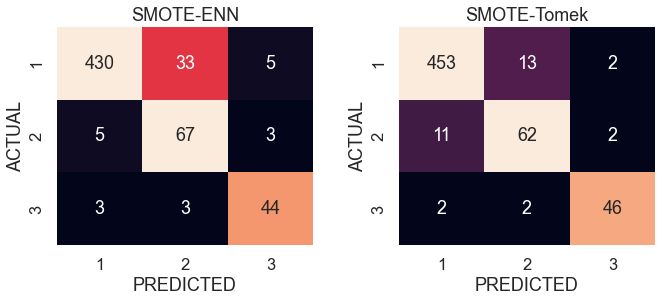

In [100]:
cm = dict()

for lab in sampler_labels:
    cm[lab] = confusion_matrix(y_test, y_test_pred[lab])
    
fig, axList = plt.subplots(nrows=1, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10, 5)

for ax,lab in zip(axList, sampler_labels):
    sns.heatmap(cm[lab], ax=ax, vmax=55, annot=True, fmt='d',
        cbar=False, xticklabels=[1,2,3], yticklabels=[1,2,3])
    ax.set(title=lab)
    ax.set_xlabel('PREDICTED')
    ax.set_ylabel('ACTUAL')
    
plt.tight_layout(pad=2.0)

In [102]:
importances_gb_sorted = pd.DataFrame(importances_gb['SMOTE-Tomek']).sort_values(by='SMOTE-Tomek', ascending=False)
importances_gb_sorted.reset_index(inplace=True)
importances_gb_sorted.reset_index(inplace=True)
importances_gb_sorted.rename(columns={'level_0':'feature_count', 'SMOTE-Tomek':'feature_importance'}, inplace=True)
importances_gb_trim = importances_gb_sorted.iloc[:11, :]
importances_gb_trim

,feature_count,index,feature_importance
0,0,ASTV,0.219815
1,1,ALTV,0.197365
2,2,Mean,0.181862
3,3,AC_fq,0.078764
4,4,Median,0.060479
5,5,DP_fq,0.050649
6,6,LB,0.047121
7,7,Max,0.030711
8,8,MSTV,0.018850
9,9,Mode,0.017519


<AxesSubplot:xlabel='feature_count', ylabel='feature_importance'>

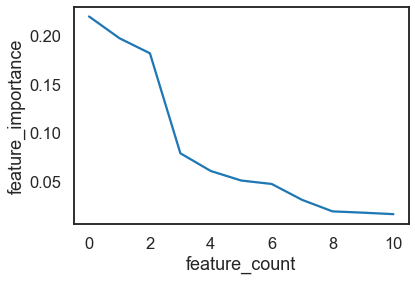

In [103]:
sns.lineplot(data=importances_gb_trim, x='feature_count', y='feature_importance')

# Model 3 - Random Forest

In [121]:
rf = RandomForestClassifier(random_state=531, oob_score=True, warm_start=False, n_jobs=-1)
oob_list = pd.DataFrame()

for lab, Xts, yts in zip(sampler_labels, Xtrains, ytrains):
    for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
        rf.set_params(n_estimators=n_trees)
        rf.fit(Xts, yts)
        oob_error = 1 - rf.oob_score_
        new_rec = pd.Series({'method':lab, 'n_trees': n_trees, 'oob': oob_error})
        oob_list = pd.concat([oob_list, new_rec], axis=1, ignore_index=True)

#rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

oob_list = oob_list.T
oob_list

c:\Users\14126\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\14126\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\14126\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\14126\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


,method,n_trees,oob
0,SMOTE,15,0.033945
1,SMOTE,20,0.025688
2,SMOTE,30,0.023547
3,SMOTE,40,0.025076
4,SMOTE,50,0.020795
5,SMOTE,100,0.020183
6,SMOTE,150,0.019878
7,SMOTE,200,0.019266
8,SMOTE,300,0.01896
9,SMOTE,400,0.019266


<AxesSubplot:xlabel='n_trees', ylabel='oob'>

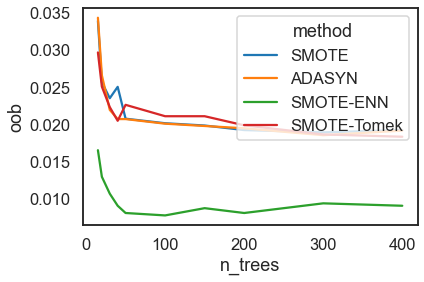

In [129]:
sns.lineplot(data=oob_list, x='n_trees', y='oob', hue='method', markers=True)

c:\Users\14126\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


[Text(0, 0.5, 'out-of-bag error')]

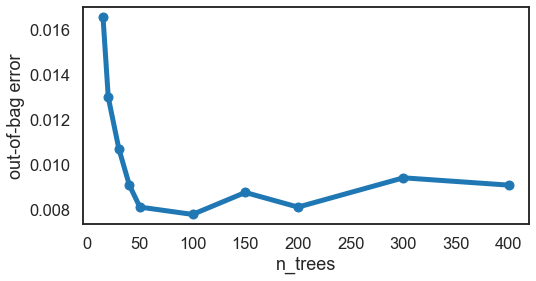

In [131]:
sns.set_context('talk')
sns.set_style('white')

ax = oob_list[oob_list['method']=='SMOTE-ENN'].plot(x='n_trees', 
    legend=False, marker='o', figsize=(8, 4), linewidth=5)
ax.set(ylabel='out-of-bag error')

In [132]:
rf = RandomForestClassifier(random_state=531, n_estimators=50, warm_start=True, n_jobs=-1)
rf.fit(X_train_SMOTEENN, y_train_SMOTEENN)
y_test_pred = rf.predict(X_test_scaled)
importances_rf = pd.DataFrame(rf.feature_importances_, index=feature_cols)

In [133]:
error_measures = pd.DataFrame()

error_measures = pd.concat([error_measures, 
                               measure_error(y_test, pd.Series(y_test_pred), 'SMOTE-ENN')], axis=1)
    
error_measures

,SMOTE-ENN
accuracy,0.929174
precision,0.767742
recall,0.952000
f1,0.850000


<AxesSubplot:>

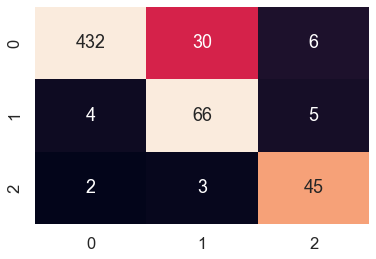

In [134]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, vmax=55, annot=True, fmt='d', cbar=False)

In [135]:
importances_rf_sorted = pd.DataFrame(importances_rf.sort_values(by=0, ascending=False))
importances_rf_sorted.reset_index(inplace=True)
importances_rf_sorted.reset_index(inplace=True)
importances_rf_sorted.rename(columns={'level_0':'feature_count', 0:'feature_importance'}, inplace=True)
importances_rf_sorted

,feature_count,index,feature_importance
0,0,ASTV,0.120078
1,1,ALTV,0.119830
2,2,Mean,0.104769
3,3,AC_fq,0.086051
4,4,DP_fq,0.079613
5,5,MSTV,0.078089
6,6,Median,0.077984
7,7,LB,0.050261
8,8,MLTV,0.045821
9,9,Mode,0.045328


<AxesSubplot:xlabel='feature_count', ylabel='feature_importance'>

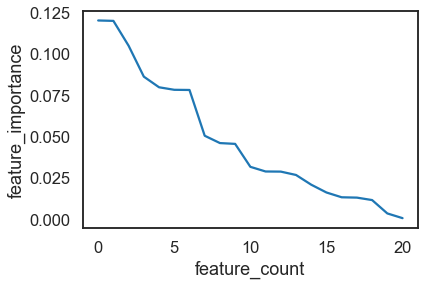

In [136]:
sns.lineplot(data=importances_rf_sorted, x='feature_count', y='feature_importance')

# Appendix

## Full List of Features with Definitions

Features: <br>
FileName: of CTG examination <br>
Date: of the examination <br>
b: start instant <br>
e: end instant <br>
LBE: baseline value (medical expert) <br>
LB: baseline value (SisPorto) <br>
AC: accelerations (SisPorto) <br>
FM: foetal movement (SisPorto)<br>
UC: uterine contractions (SisPorto)<br>
ASTV: percentage of time with abnormal short term variability (SisPorto)<br>
mSTV: mean value of short term variability (SisPorto)<br>
ALTV: percentage of time with abnormal long term variability (SisPorto)<br>
mLTV: mean value of long term variability (SisPorto)<br>
DL: light decelerations<br>
DS: severe decelerations<br>
DP: prolongued decelerations<br>
DR: repetitive decelerations<br>
Width: histogram width<br>
Min: low freq. of the histogram<br>
Max: high freq. of the histogram<br>
Nmax: number of histogram peaks<br>
Nzeros: number of histogram zeros<br>
Mode: histogram mode<br>
Mean: histogram mean<br>
Median: histogram median<br>
Variance: histogram variance<br>
Tendency: histogram tendency: -1=left assymetric; 0=symmetric; 1=right assymetric<br>
A: calm sleep<br>
B: REM sleep<br>
C: calm vigilance<br>
D: active vigilance<br>
SH: shift pattern (A or Susp with shifts)<br>
AD: accelerative/decelerative pattern (stress situation)<br>
DE: decelerative pattern (vagal stimulation)<br>
LD: largely decelerative pattern<br>
FS: flat-sinusoidal pattern (pathological state)<br>
SUSP: suspect pattern<br>
CLASS: Class code (1 to 10) for classes A to SUSP<br>
NSP:- Normal=1; Suspect=2; Pathologic=3<br>